In [21]:
import os, random, math, itertools
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd

np.random.seed(42)
tf.random.set_seed(42)

IMG_HEIGHT, IMG_WIDTH = 64, 256
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

In [22]:
from huggingface_hub import snapshot_download
import zipfile

dataset_dir = snapshot_download(
  repo_id="YCAI3/HCI_P2",
  repo_type="dataset",
  local_dir="./HCI_Dataset",
  ignore_patterns=[".gitattributes"]
)

print("Dataset downloaded to:", dataset_dir)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

# Extract the dataset if not already extracted
if not os.path.exists(extract_dir):
  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

# Base path where the actual images live
base_path = "./HCI_Dataset/unzipped/HCI_Dataset"
assert os.path.exists(base_path), f"Expected folder not found: {base_path}"


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset downloaded to: /content/HCI_Dataset


In [23]:
# Recursively collect *.jpg
image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))

def get_word_label_from_filename(path):
  fname = os.path.basename(path)
  parts = fname.split("_")
  return parts[1] if len(parts) >= 2 else ""

data = pd.DataFrame({
  "path": image_paths,
  "label": [get_word_label_from_filename(p) for p in image_paths]
})

# Basic sanity check
print(data.sample(5))
print("Unique sample words:", data['label'].nunique())


Total images found: 609656
                                                     path          label
497818  ./HCI_Dataset/unzipped/HCI_Dataset/116/5/213_6...             60
180397  ./HCI_Dataset/unzipped/HCI_Dataset/193/3/445_P...          Plaid
232696  ./HCI_Dataset/unzipped/HCI_Dataset/59/7/24_For...     Formatting
19774   ./HCI_Dataset/unzipped/HCI_Dataset/64/4/161_Na...        Napping
244604  ./HCI_Dataset/unzipped/HCI_Dataset/29/3/388_re...  remonstrances
Unique sample words: 237485


In [24]:
all_text = "".join(data["label"].astype(str).tolist())
unique_chars = sorted(list(set(all_text)))
print("Unique chars ({}):".format(len(unique_chars)), unique_chars[:80], "...")

char_to_num = layers.StringLookup(
  vocabulary=unique_chars,
  num_oov_indices=0,
  mask_token=None
)

num_to_char = layers.StringLookup(
  vocabulary=char_to_num.get_vocabulary(),
  invert=True,
  num_oov_indices=0,
  mask_token=None
)

test_word = data["label"].iloc[0]
enc = char_to_num(tf.strings.unicode_split(test_word, "UTF-8"))
dec = tf.strings.reduce_join(num_to_char(enc)).numpy().decode("utf-8")
print("Test label:", test_word, "| Encoded len:", enc.shape[0], "| Decoded:", dec)


Unique chars (62): ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] ...
Test label: Duelists | Encoded len: 8 | Decoded: Duelists


In [25]:
def preprocess_example(path, label_str):
  img_bytes = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img_bytes, channels=1)
  img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
  img = tf.cast(img, tf.float32) / 255.0

  label_chars = tf.strings.unicode_split(label_str, "UTF-8")
  label_ids = char_to_num(label_chars)

  return img, label_ids


In [26]:
idx = np.arange(len(data))
np.random.shuffle(idx)

train_end = int(0.8 * len(idx))
val_end   = int(0.9 * len(idx))

train_idx = idx[:train_end]
val_idx   = idx[train_end:val_end]
test_idx  = idx[val_end:]

train_paths = data["path"].values[train_idx]
train_labels= data["label"].values[train_idx]
val_paths   = data["path"].values[val_idx]
val_labels  = data["label"].values[val_idx]
test_paths  = data["path"].values[test_idx]
test_labels = data["label"].values[test_idx]

print("Splits -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

train_raw = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_raw   = tf.data.Dataset.from_tensor_slices((val_paths,   val_labels))
test_raw  = tf.data.Dataset.from_tensor_slices((test_paths,  test_labels))

train_mapped = train_raw.map(preprocess_example, num_parallel_calls=AUTOTUNE)
val_mapped   = val_raw.map(preprocess_example,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_raw.map(preprocess_example,  num_parallel_calls=AUTOTUNE)


Splits -> train: 487724 val: 60966 test: 60966


In [27]:
def _to_dtypes(img, label_ids):
  img = tf.cast(img, tf.float32)
  label_ids = tf.cast(label_ids, tf.int32)
  return img, label_ids

train_mapped = train_mapped.map(_to_dtypes, num_parallel_calls=AUTOTUNE)
val_mapped   = val_mapped.map(_to_dtypes,   num_parallel_calls=AUTOTUNE)
test_mapped  = test_mapped.map(_to_dtypes,  num_parallel_calls=AUTOTUNE)

PADDING_VALUES = (
  tf.constant(0.0, dtype=tf.float32),
  tf.constant(-1,  dtype=tf.int32)
)

train_ds = (train_mapped.shuffle(8192, reshuffle_each_iteration=True).padded_batch(BATCH_SIZE,padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),padding_values=PADDING_VALUES).prefetch(AUTOTUNE))

val_ds = (val_mapped.padded_batch(BATCH_SIZE,padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),padding_values=PADDING_VALUES).prefetch(AUTOTUNE))

test_ds = (test_mapped.padded_batch(BATCH_SIZE,padded_shapes=([IMG_HEIGHT, IMG_WIDTH, 1], [None]),padding_values=PADDING_VALUES).prefetch(AUTOTUNE))

for imgs, labs in train_ds.take(1):
  print("Batch images:", imgs.shape, imgs.dtype)
  print("Batch labels shape:", labs.shape, labs.dtype)
  print("First label (padded ids):", labs[0][:20].numpy())
  break


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels shape: (32, 15) <dtype: 'int32'>
First label (padded ids): [22 30 21 29 18 25 21 14 28 -1 -1 -1 -1 -1 -1]


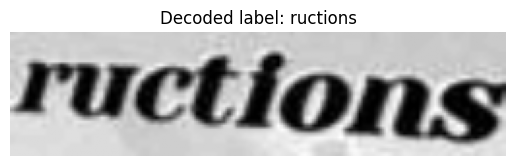

In [28]:
def decode_label_ids(label_ids_tensor):
  valid = tf.boolean_mask(label_ids_tensor, label_ids_tensor != -1)
  chars = num_to_char(valid)
  return tf.strings.reduce_join(chars).numpy().decode("utf-8")

import matplotlib.pyplot as plt

for imgs, labs in train_ds.take(1):
  idx = 0
  plt.imshow(tf.squeeze(imgs[idx]), cmap='gray')
  plt.title("Decoded label: " + decode_label_ids(labs[idx]))
  plt.axis('off')
  plt.show()
  break


In [29]:
def ctc_loss_func(y_true, y_pred):
  y_true = tf.cast(y_true, tf.int32)
  y_pred = tf.cast(y_pred, tf.float32)

  B = tf.shape(y_true)[0]
  T = tf.shape(y_pred)[1]
  label_len = tf.reduce_sum(tf.cast(y_true != -1, tf.int32), axis=1)  # (B,)

  label_len = tf.minimum(label_len, T)

  y_true_fixed = tf.where(y_true < 0, tf.zeros_like(y_true), y_true)

  input_len = tf.fill([B, 1], T)
  label_len = tf.reshape(label_len, [B, 1])

  return tf.keras.backend.ctc_batch_cost(y_true_fixed, y_pred, input_len, label_len)


In [30]:
from tensorflow.keras import layers, models

def build_crnn_lstm(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=None):
  assert vocab_size is not None, "Pass vocab_size=len(unique_chars)+1 (for CTC blank)."

  inp = layers.Input(shape=(img_h, img_w, 1), name="image")

  x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(inp)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)

  x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.2)(x)

  Hp = img_h // 8
  Wp = img_w // 8
  C  = 128

  x = layers.Permute((2, 1, 3))(x)
  x = layers.Reshape((Wp, Hp * C))(x)

  x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(64,  return_sequences=True))(x)

  out = layers.Dense(vocab_size, activation="softmax")(x)

  return models.Model(inputs=inp, outputs=out, name="CRNN_LSTM")

VOCAB_SIZE = len(unique_chars) + 1
crnn_lstm = build_crnn_lstm(vocab_size=VOCAB_SIZE)

crnn_lstm.summary()


Model: "CRNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 256, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_5 (Permute)             │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 32, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 32, 256)        │     1,180,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 32, 128)        │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32, 63)         │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,575,231 (6.01 MB)

 Trainable params: 1,575,231 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Peek at one batch
imgs, labs = next(iter(train_ds))
print("Batch images:", imgs.shape, imgs.dtype)
print("Batch labels:", labs.shape, labs.dtype)

probe = crnn_lstm(imgs[:1])
print("Model output shape (B, T, C):", probe.shape)


Batch images: (32, 64, 256, 1) <dtype: 'float32'>
Batch labels: (32, 13) <dtype: 'int32'>
Model output shape (B, T, C): (1, 32, 63)


In [32]:
SUB_TRAIN = 20000
SUB_VAL   = 4000

subset_train = (
  train_ds
  .unbatch()
  .take(SUB_TRAIN)
  .batch(BATCH_SIZE)
  .repeat()
  .prefetch(tf.data.AUTOTUNE)
)
subset_val = (
  val_ds
  .unbatch()
  .take(SUB_VAL)
  .batch(BATCH_SIZE)
  .repeat()
  .prefetch(tf.data.AUTOTUNE)
)

steps_per_epoch  = (SUB_TRAIN + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (SUB_VAL   + BATCH_SIZE - 1) // BATCH_SIZE

crnn_lstm.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss=ctc_loss_func
)

callbacks = [
  keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_lstm_adam = crnn_lstm.fit(
  subset_train,
  validation_data=subset_val,
  epochs=10,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  verbose=1
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - loss: 41.5026 - val_loss: 30.9441
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 30.7357 - val_loss: 30.4084
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 30.2053 - val_loss: 29.7618
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 29.5923 - val_loss: 29.0970
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 28.9004 - val_loss: 28.6698
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 28.4452 - val_loss: 28.0915
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 28.1194 - val_loss: 27.9202
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 27.6393 - val_loss: 27.7846
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 27.3070 - val_loss: 27.2042
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - loss: 27.0383 - val_loss: 27.0149


In [33]:
SUB_TRAIN = 20000
SUB_VAL   = 4000

subset_train = (
  train_ds
  .unbatch()
  .take(SUB_TRAIN)
  .batch(BATCH_SIZE)
  .repeat()
  .prefetch(tf.data.AUTOTUNE)
)
subset_val = (
  val_ds
  .unbatch()
  .take(SUB_VAL)
  .batch(BATCH_SIZE)
  .repeat()
  .prefetch(tf.data.AUTOTUNE)
)

steps_per_epoch  = (SUB_TRAIN + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (SUB_VAL   + BATCH_SIZE - 1) // BATCH_SIZE

crnn_lstm.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=1e-5),
  loss=ctc_loss_func
)

callbacks = [
  keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
  keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_lstm_sgd = crnn_lstm.fit(
  subset_train,
  validation_data=subset_val,
  epochs=10,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - loss: 26.7854 - val_loss: 26.7883
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 26.6638 - val_loss: 26.7699
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 26.5576 - val_loss: 26.7399
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 26.5426 - val_loss: 26.7251
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 26.6713 - val_loss: 26.7117
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - loss: 26.4685 - val_loss: 26.7104
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 26.6439 - val_loss: 26.7051
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 26.5294 - val_loss: 26.6909
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 26.5263 - val_loss: 26.6848
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - loss: 26.6533 - val_loss: 26.7057


In [34]:
best_val = min(history_lstm_adam.history['val_loss'])
print(f"Best val_loss: {best_val:.4f}")


Best val_loss: 27.0149


In [35]:
def build_crnn_gru(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=None):
  assert vocab_size is not None

  inp = layers.Input(shape=(img_h, img_w, 1), name="image")
  x = layers.Conv2D(64, 3, padding="same", activation="relu")(inp); x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(128,3, padding="same", activation="relu")(x);   x = layers.MaxPooling2D(2)(x)
  x = layers.Conv2D(128,3, padding="same", activation="relu")(x);   x = layers.MaxPooling2D(2)(x)

  Hp = img_h // 8; Wp = img_w // 8; C = 128
  x = layers.Permute((2,1,3))(x)
  x = layers.Reshape((Wp, Hp*C))(x)

  x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
  x = layers.Bidirectional(layers.GRU(64,  return_sequences=True))(x)

  out = layers.Dense(vocab_size, activation="softmax")(x)
  return models.Model(inp, out, name="CRNN_GRU")

VOCAB_SIZE = len(unique_chars) + 1
crnn_gru = build_crnn_gru(vocab_size=VOCAB_SIZE)

crnn_gru.summary()

Model: "CRNN_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 256, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_6 (Permute)             │ (None, 32, 8, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 32, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 32, 256)        │       886,272 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 32, 128)        │       123,648 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32, 63)         │         8,127 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,240,127 (4.73 MB)

 Trainable params: 1,240,127 (4.73 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
VOCAB_SIZE = len(unique_chars) + 1  # if not already defined

crnn_gru_adam = build_crnn_gru(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=VOCAB_SIZE)
crnn_gru_adam.compile(
  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
  loss=ctc_loss_func
)

history_gru_adam = crnn_gru_adam.fit(
  subset_train,
  validation_data=subset_val,
  epochs=10,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - loss: 41.6973 - val_loss: 30.5885
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 30.4584 - val_loss: 30.0638
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 29.8859 - val_loss: 29.3839
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - loss: 29.1673 - val_loss: 28.8123
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 28.5773 - val_loss: 28.3586
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 28.1171 - val_loss: 27.8551
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 27.6454 - val_loss: 27.2972
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 26.9454 - val_loss: 26.8601
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - loss: 26.4188 - val_loss: 26.0113
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 33s 52ms/step - loss: 25.6392 - val_loss: 25.2546


In [37]:
VOCAB_SIZE = len(unique_chars) + 1  # if not already defined

crnn_gru_sgd = build_crnn_gru(img_h=IMG_HEIGHT, img_w=IMG_WIDTH, vocab_size=VOCAB_SIZE)
crnn_gru_sgd.compile(
  optimizer=keras.optimizers.SGD(learning_rate=1e-2),
  loss=ctc_loss_func
)

history_gru_sgd = crnn_gru_sgd.fit(
  subset_train,
  validation_data=subset_val,
  epochs=10,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 51ms/step - loss: 37.6051 - val_loss: 31.2061
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 31.1508 - val_loss: 30.8396
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - loss: 31.0254 - val_loss: 30.7234
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 30.6334 - val_loss: 30.7065
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 30.4408 - val_loss: 30.1050
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 30.0999 - val_loss: 29.7368
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 29.6414 - val_loss: 29.1372
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 29.2937 - val_loss: 28.7603
Epoch 9/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 28.4637 - val_loss: 27.6778
Epoch 10/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - loss: 27.4413 - val_loss: 26.3984


In [ ]:
from tensorflow.keras import layers, models, applications
import tensorflow as tf
import math

inp = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1), name="image")

x = layers.Conv2D(3, (1,1), padding='same', name='to_rgb')(inp)

base = applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

conv3_model = models.Model(
    inputs=base.input,
    outputs=base.get_layer('conv3_block4_out').output,
    name='ResNet50_conv3_trunk'
)

feat = conv3_model(x)

unfreeze = False
for layer in conv3_model.layers:
    if layer.name.startswith('conv3_block1'):
        unfreeze = True
    layer.trainable = unfreeze

Hp = IMG_HEIGHT // 8
Wp = IMG_WIDTH  // 8
C  = int(feat.shape[-1])

y = layers.Permute((2, 1, 3))(feat)
y = layers.Reshape((Wp, Hp * C))(y)

y = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(y)
y = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(y)

out = layers.Dense(VOCAB_SIZE, activation='softmax')(y)

crnn_resnet_lstm = models.Model(inputs=inp, outputs=out, name="CRNN_ResNet50_LSTM")

crnn_resnet_lstm.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=ctc_loss_func)

SUB_TRAIN = 20000
SUB_VAL   = 4000

subset_train = (
    train_ds.unbatch().take(SUB_TRAIN).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
)
subset_val = (
    val_ds.unbatch().take(SUB_VAL).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
)

steps_per_epoch  = (SUB_TRAIN + BATCH_SIZE - 1) // BATCH_SIZE
validation_steps = (SUB_VAL   + BATCH_SIZE - 1) // BATCH_SIZE

history_resnet_lstm_adam = crnn_resnet_lstm.fit(
    subset_train,
    validation_data=subset_val,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    verbose=1
)


In [39]:
import json

crnn_lstm.save("crnn_lstm_adam.keras")

with open("vocab.json", "w") as f:
  json.dump(unique_chars, f)

with open ("history_lstm_adam.json", "w") as f:
  json.dump(history_lstm_adam.history, f)


In [41]:
  with open("vocab.json", "r") as f:
    vocab = json.load(f)

  char_to_num = layers.StringLookup(
    vocabulary=vocab,
    num_oov_indices=0,
    mask_token=None
  )
  num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    num_oov_indices=0,
    mask_token=None
  )
  # The CTC blank is the last index by construction (len(vocab))
  blank_index = len(vocab)

inference_model = keras.models.load_model("crnn_lstm_adam.keras", compile=False)

In [42]:
import numpy as np
import tensorflow as tf

def ctc_decoder(y_pred, blank_id):
  # Argmax over classes (C)
  best_path = np.argmax(y_pred, axis=-1)  # (B, T)

  decoded_texts = []
  for seq in best_path:
    prev = -1
    chars = []
    for idx in seq:
      if idx != prev and idx != blank_id:
        # map idx -> char via num_to_char layer
        ch = num_to_char(tf.constant([idx]))[0].numpy().decode("utf-8")
        chars.append(ch)
        prev = idx
    decoded_texts.append("".join(chars))
  return decoded_texts
